# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


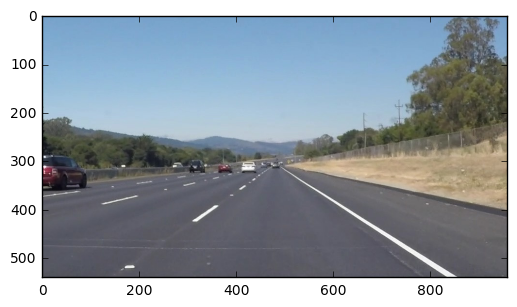

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from builtins import round

left_lane_prior = [None,None]
right_lane_prior = [None,None]
points_left_prior = []
points_right_prior = []



def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def fit_curve(points, x_min, x_max):
    """
    Fit a curve using polyfit function
    """
    points = np.array(points)
    x = points[:,0]
    y = points[:,1]

    z = np.polyfit(x, y, 2)
    curve_model = np.poly1d(z)

    # calculate points using model
    x_new = np.linspace(x_min, x_max, 100)
    y_new = curve_model(x_new)
    
    points_new = np.int32([[x_new[i],y_new[i]] for i in range(len(x_new))])
    
    return points_new

def fit_average_line(lines, target_x, x_max, y_min, y_max, lane_prior):
    """
    Fit a straight line using the average of lines and mixing with lane_prior
    
    lane_prior is the prior lines intercept and slope 
    """
    mix = 0.2
    lines = np.array(lines)
    
    if(len(lines) == 0):
        mix = 0
        b_avg = 0
        m_avg  = 0
    else:
        mix = 0.2
        b_list = lines[:,1]
        m_list = lines[:,0]
        b_avg = sum(b_list)/len(b_list)
        m_avg  = sum(m_list)/len(m_list)
    
    if( lane_prior[0] is not None or lane_prior[1] is not None):
        b_avg = b_avg * mix + lane_prior[1] * (1-mix)
        m_avg = m_avg * mix + lane_prior[0] * (1-mix)
    
    x_tmp = int(round((y_max-b_avg)/m_avg))
    y_tmp = int(round((m_avg*target_x + b_avg)))
    
    if(x_tmp < x_max and x_tmp > 0):
        line = [[x_tmp,y_max,int(round((y_min-b_avg)/m_avg)),round(y_min)]]
    else:
        line = [[target_x,y_tmp,int(round((y_min-b_avg)/m_avg)),round(y_min)]]
    
    return line, m_avg,b_avg
    
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=13):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def draw_lane_lines_curved(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Finds and draw left and right lane lines on a image using curve model
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    imshape = line_img.shape
    b_left = []
    m_left = []
    b_right = []
    m_right = []
    
    points_left = []
    points_right = []
    
    count = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            b = y2 - m * x2
            
            if(np.isinf(m) or abs(math.atan(m)*180/np.pi) < 15):
                continue
            if(m < 0):
                points_left.append([x1,y1])
                points_left.append([x2,y2])
                b_left.append(b)
                m_left.append(m)
            else:
                points_right.append([x1,y1])
                points_right.append([x2,y2])
                b_right.append(b)
                m_right.append(m)
             
    #get left lane line
    if(len(b_left) > 0):
        linesMB = [[m_left[i],b_left[i]] for i in range(len(b_left))]
        left_line, m_avg, b_avg  = fit_average_line(linesMB,0,imshape[1], imshape[0]*0.6,imshape[0],left_lane_prior)
        points_left.append([left_line[0][0],left_line[0][1]])
        new_points = fit_curve(points_left,0,imshape[1]*0.48)
        cv2.polylines(line_img,[new_points],False,(255,0,255),15)    
    #get right lane line
    if(len(b_right) > 0):
        linesMB = [[m_right[i],b_right[i]] for i in range(len(b_right))] 
        right_line, m_avg, b_avg = fit_average_line(linesMB,imshape[1],imshape[1],imshape[0]*0.6,imshape[0],right_lane_prior)
        points_right.append([right_line[0][0],right_line[0][1]])
        draw_lines(line_img, [right_line])
        new_points = fit_curve(points_right,imshape[1]*0.55,imshape[1])
        cv2.polylines(line_img,[new_points],False,(255,0,255),15)
    
    return line_img


def draw_lane_lines_straight(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Finds and draw left and right lane lines on a image using straight line model
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    imshape = line_img.shape
    b_left = []
    m_left = []
    b_right = []
    m_right = []
    lane_lines = []
    
    count = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #find slope and intercept
            m = ((y2-y1)/(x2-x1))
            b = y2 - m * x2
            
            #exclude vertical lines (inf slope) and near horizontal lines
            if(np.isinf(m) or abs(math.atan(m)*180/np.pi) < 15):
                continue
            #sort based on slope value
            if(m < 0):
                b_left.append(b)
                m_left.append(m)
            else:
                b_right.append(b)
                m_right.append(m)
             
    #get left lane line
    if(len(b_left) > 0 or left_lane_prior[0] is not None):
        linesMB = [[m_left[i],b_left[i]] for i in range(len(b_left))]
        left_line, m_avg, b_avg = fit_average_line(linesMB,0,imshape[1], imshape[0]*0.6,imshape[0],left_lane_prior)
        lane_lines.append(left_line)
        left_lane_prior[0] = m_avg
        left_lane_prior[1] = b_avg
    #get right lane line
    if(len(b_right) > 0 or right_lane_prior[0] is not None):
        linesMB = [[m_right[i],b_right[i]] for i in range(len(b_right))] 
        right_line, m_avg, b_avg = fit_average_line(linesMB,imshape[1],imshape[1],imshape[0]*0.6,imshape[0], right_lane_prior)
        lane_lines.append(right_line)
        right_lane_prior[0] = m_avg
        right_lane_prior[1] = b_avg
        
    draw_lines(line_img, lane_lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'new_solidWhiteRight.jpg',
 'new_whiteCarLaneSwitch.jpg',
 'new_solidYellowCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'new_solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'new_solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'new_solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


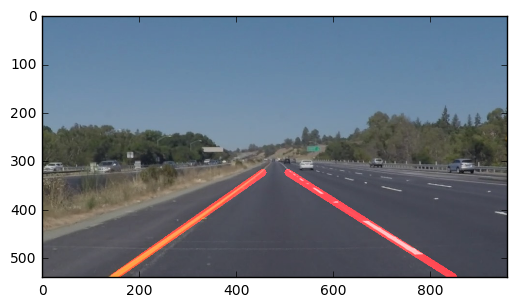

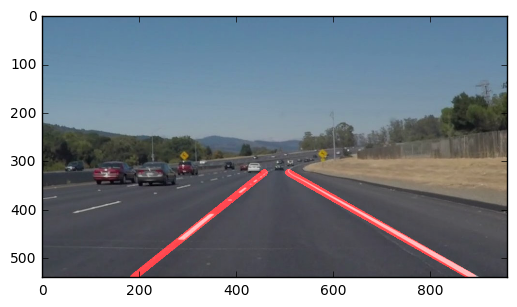

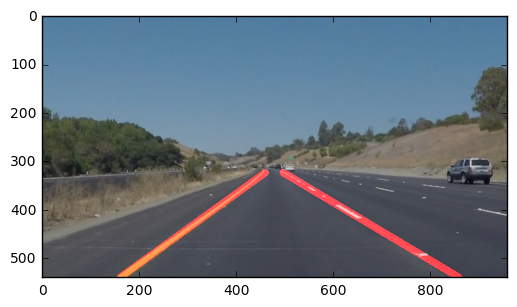

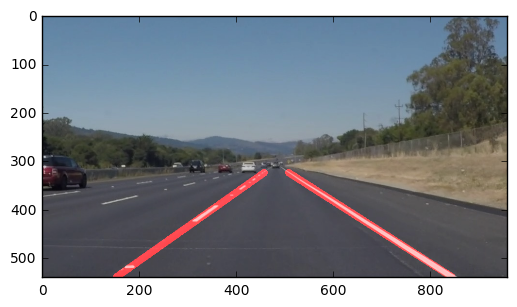

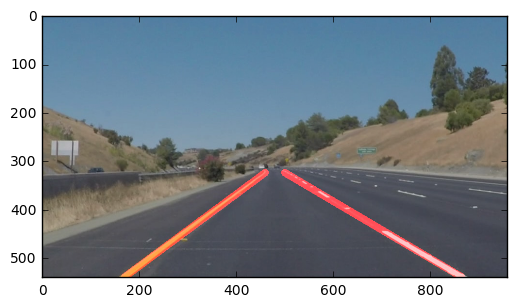

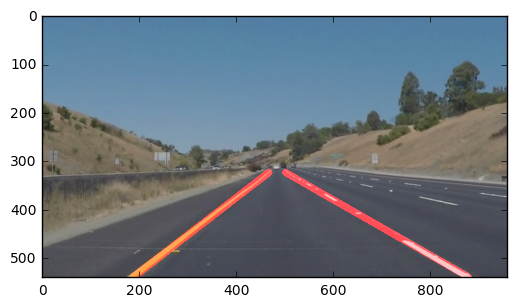

In [13]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
images = os.listdir("test_images/")

for i,x in enumerate(images):
    left_lane_prior = [None,None]
    right_lane_prior = [None,None]
    points_left_prior = []
    points_right_prior = []
    
    image = mpimg.imread("test_images/" + x)
    ysize = image.shape[0]
    print('This image is:', type(image), 'with dimesions:', image.shape)
    himage = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    hsvs = cv2.split(himage)
    
    img = hsvs[2]
    imshape = image.shape
    img = gaussian_blur(img, 5)
    img = canny(img,50,150) 
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.48, imshape[0]*0.6), (imshape[1]*0.52,  imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    img = region_of_interest(img, vertices)
    

    img = draw_lane_lines_straight(img,1, np.pi * 1/180, 50, 50, 90)
    plot_image = weighted_img(img, image, α=0.8, β=0.9, λ=0.0)
    plt.figure(i*2)
    plt.imshow(plot_image,cmap="gray")#call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    plt.imsave("test_images/" + "new_" + x, plot_image)
    



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below 
    ysize = image.shape[0]
    himage = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    hsvs = cv2.split(himage)
    
    #Use value channel from HSV to better see yellow lane lines
    img = hsvs[2]
    imshape = image.shape
    
    img = gaussian_blur(img, 5)
    img = canny(img,50,150) 
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.48, imshape[0]*0.6), (imshape[1]*0.52, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    img = region_of_interest(img, vertices)
    
    #Function for drawing lanes lines using Hough Transform
    img = draw_lane_lines_straight(img,1, np.pi * 1/180, 50, 50, 90)
    
    result = weighted_img(img, image, α=0.8, β=0.9, λ=0.0)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [7]:
left_lane_prior = [None,None]
right_lane_prior = [None,None]
points_left_prior = []
points_right_prior = []
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 33.4 s, sys: 640 ms, total: 34.1 s
Wall time: 13.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
left_lane_prior = [None,None]
right_lane_prior = [None,None]
points_left_prior = []
points_right_prior = []
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:40<00:00, 10.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 46s, sys: 1.24 s, total: 1min 47s
Wall time: 41.3 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [14]:
"""
My pipeline for lane line finding:

1. Convert image to HSV space and extract out Value channel, from my experiments the Value channel gave better
results than the greyscale image, as the Value channel was better for seeing the bright yellow line
2. Gaussian blur with kernel size of 5
3. Canny edge detection with a lower threshold of 50 and upper threshold of 150
4. Extract out region of interest starting 0.6 of the way down in the y direction. The region is roughly a triangle
with the bottom conners in the left and right bottom corners of the image and peaking to a flat top at x ~ 0.5
5. Apply hough transform with rho, theta, threshold, min_line_len, max_line_gap equal to 1, 1 degree, 50, 50, 90
6.Separate lines with negative slope to the left line and positive slope to the right line and exclude lines with
infinite slope (vertical lines) and lines that are less than 15 degrees from the horizontal plane.
7. Take the average of all the left lines and again for all the right lines to get the average m and b value for
both left and right lines
8. Mix calculated line with prior lane line values to prevent jerky movements
9. Use calculated m and b values to find lines start and end points going from largest y value to smallest y value

Note: steps 5-9 are contained in the draw_lane_lines_straight function

Extra Challenge: 
In order to complete the extra challenge I saved the prior frames left and right line slope and intercept 
values and mixed them with the current frames slope and intercept values. This made the pipeline more robust with
the curving lane line. Another addition was if the Hough transform did not find enough lines for either
the left or right lines then I would still draw a line using the prior saved line model, this prevented the line
from flickering which occured quite often with the curving lane lines.

Although my pipeline works well on the videos provided for the project, there are some areas I think it could be improved.
First, to make this algorithm more robust I would look into adding a curved line model, since I think my current
algorithm would fail in situations where the lane line is extremeley curved like on some overpass exit ramps. I did
explore using numpy's polyfit function but could not make it work better than my current pipeline.Second, modifying
the region of interest selection to be more dynamic would help improve this algorithm, as the lane line are not always 
going to be within the region I hardcoded. Third, canny edge detection requires parameter tuning, as a result 
variable condition eg, rain, snow, lighting could mean it needs to be retuned, therefore using a parameterless
edge detection method would be beneficial in this situation. 


"""

"\nMy pipeline for lane line finding:\n\n1. Convert image to HSV space and extract out Value channel, from my experiments the Value channel gave better\nresults than the greyscale image, as the Value channel was better for seeing the bright yellow line\n2. Gaussian blur with kernel size of 5\n3. Canny edge detection with a lower threshold of 50 and upper threshold of 150\n4. Extract out region of interest starting 0.6 of the way down in the y direction. The region is roughly a triangle\nwith the bottom conners in the left and right bottom corners of the image and peaking to a flat top at x ~ 0.5\n5. Apply hough transform with rho, theta, threshold, min_line_len, max_line_gap equal to 1, 1 degree, 50, 50, 90\n6.Separate lines with negative slope to the left line and positive slope to the right line and exclude lines with\ninfinite slope (vertical lines) and lines that are less than 15 degrees from the horizontal plane.\n7. Take the average of all the left lines and again for all the rig

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
left_lane_prior = [None,None]
right_lane_prior = [None,None]
points_left_prior = []
points_right_prior = []

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:31<00:00,  8.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 9s, sys: 984 ms, total: 1min 10s
Wall time: 32.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))